In [15]:
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.datasets import make_moons 
from visualization import plot_2d_classifier, plot_2d_data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X,y = make_moons(n_samples=100, noise=0.05)


In [16]:
# add an outlier 

X = np.concatenate((X, [[-1.5,0.0]]))
y = np.concatenate((y, [1]))

In [17]:
# convert to -1/+1 labels 
y = 2*y-1

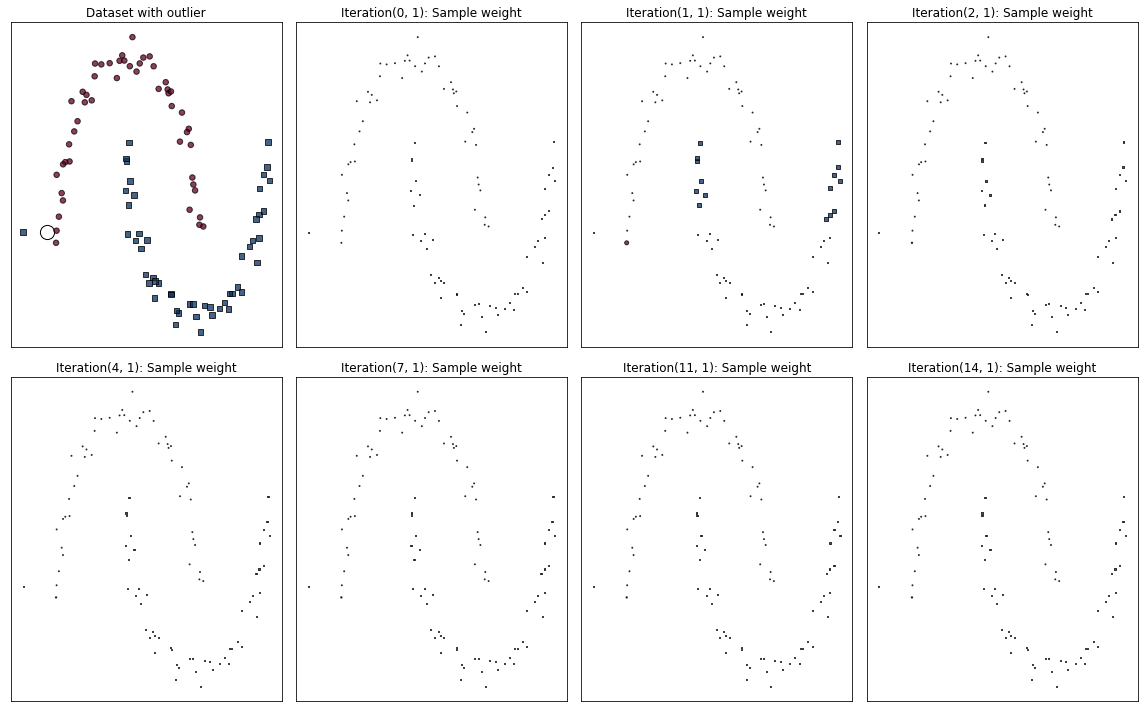

In [26]:
n_samples, n_features = X.shape 
n_estimators = 20
W = np.ones((n_samples,))
ensemble = []

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,10))

ax[0,0].scatter([-1.15],[0.0], marker='o', s=200, c='w', edgecolors='k')
plot_2d_data(ax[0,0], X, y, alpha=0.75, s=30, title="Dataset with outlier", colormap='RdBu')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
axis_index = 0

for t in range(n_estimators):
    W = W/np.sum(W)
    #plot in different sizes proportional to their weights 
    s = W / np.max(W)
    s[(0.00 <= s) & (s < 0.25)] = 2
    s[(0.25 <= s) & (s < 0.5)] = 16
    s[(0.5 <= s) & (s < 0.75)] = 64
    s[(0.75 <= s) & (s < 1.00)] = 128
    
    if t in [0,1,2,4,7,11,14]:
        axis_index += 1
        r,c = np.divmod(axis_index, 4)
        title = "Iteration{0}: Sample weight".format((t,+1))
        plot_2d_data(ax[r,c], X, y, alpha=0.75, s=s, title=title, colormap = 'RdBu')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        
    h = DecisionTreeClassifier(max_depth=1)
    h.fit(X, y, sample_weight=W)
    y_pred = h.predict(X)
    
    e = 1 - accuracy_score(y, y_pred, sample_weight=W) # weight error 
    a = 0.5*(np.log(1-e)/e)
    m = (y==y_pred)* 1 + (y != y_pred)*-1 # correctly and misclassification 
    W *= np.exp(-a*m)
    ensemble.append((a,h))

fig.tight_layout()
plt.show()

In [120]:
import pandas as pd 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

In [121]:
colnames = ['age', 'sex', 'cp', 'trestpbs', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

In [122]:
df = pd.read_csv("data/heart_disease.csv", names=colnames)
df.head()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [123]:
df['num'].value_counts()

0    188
1    106
Name: num, dtype: int64

In [124]:
df.shape

(294, 14)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestpbs  294 non-null    object 
 4   chol      294 non-null    object 
 5   fbs       294 non-null    object 
 6   restecg   294 non-null    object 
 7   thalach   294 non-null    object 
 8   exang     294 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     294 non-null    object 
 11  ca        294 non-null    object 
 12  thal      294 non-null    object 
 13  num       294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [126]:
df.isnull().sum()

age         0
sex         0
cp          0
trestpbs    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [127]:
df['slope'].value_counts()

?    190
2     91
1     12
3      1
Name: slope, dtype: int64

In [128]:
df[df.slope!='?'].slope.mode()

0    2
dtype: object

In [129]:
df = df.replace('?', np.nan)

In [130]:
df['slope'].fillna(df[df.slope!=np.nan].slope.mode()[0], inplace=True)
df.head()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,2,NaN,NaN,0
1,29,1,2,120,243,0,0,160,0,0.0,2,NaN,NaN,0
2,29,1,2,140,NaN,0,0,170,0,0.0,2,NaN,NaN,0
3,30,0,1,170,237,0,1,170,0,0.0,2,NaN,6,0
4,31,0,2,100,219,0,1,150,0,0.0,2,NaN,NaN,0


In [131]:
df['thal'].fillna(df[df.thal!=np.nan].thal.mode()[0], inplace=True)
df.head()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,2,NaN,7,0
1,29,1,2,120,243,0,0,160,0,0.0,2,NaN,7,0
2,29,1,2,140,NaN,0,0,170,0,0.0,2,NaN,7,0
3,30,0,1,170,237,0,1,170,0,0.0,2,NaN,6,0
4,31,0,2,100,219,0,1,150,0,0.0,2,NaN,7,0


In [132]:
df['ca'].fillna(df[df.ca!=np.nan].ca.mode()[0], inplace=True)

df['chol'].fillna(df[df.chol!=np.nan].chol.mode()[0], inplace=True)
df.head()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,2,0,7,0
1,29,1,2,120,243,0,0,160,0,0.0,2,0,7,0
2,29,1,2,140,230,0,0,170,0,0.0,2,0,7,0
3,30,0,1,170,237,0,1,170,0,0.0,2,0,6,0
4,31,0,2,100,219,0,1,150,0,0.0,2,0,7,0


In [133]:
df['chol'] = df.chol.astype("float64")
df['trestpbs'] = df.chol.astype("float64")
df['sex'] = df.chol.astype("object")
df['cp'] = df.chol.astype("object")


df.dtypes

age           int64
sex          object
cp           object
trestpbs    float64
chol        float64
fbs          object
restecg      object
thalach      object
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
num           int64
dtype: object

In [134]:
df['trestpbs'].fillna(df['trestpbs'].median(), inplace=True)
df['fbs'].fillna(df['fbs'].median(), inplace=True)
df['restecg'].fillna(df['restecg'].median(), inplace=True)
df['thalach'].fillna(df['thalach'].median(), inplace=True)

df.head()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,132,132,132.0,132.0,0,2,185,0,0.0,2,0,7,0
1,29,243,243,243.0,243.0,0,0,160,0,0.0,2,0,7,0
2,29,230,230,230.0,230.0,0,0,170,0,0.0,2,0,7,0
3,30,237,237,237.0,237.0,0,1,170,0,0.0,2,0,6,0
4,31,219,219,219.0,219.0,0,1,150,0,0.0,2,0,7,0


TypeError: 'value' must be an instance of str or bytes, not a numpy.float64

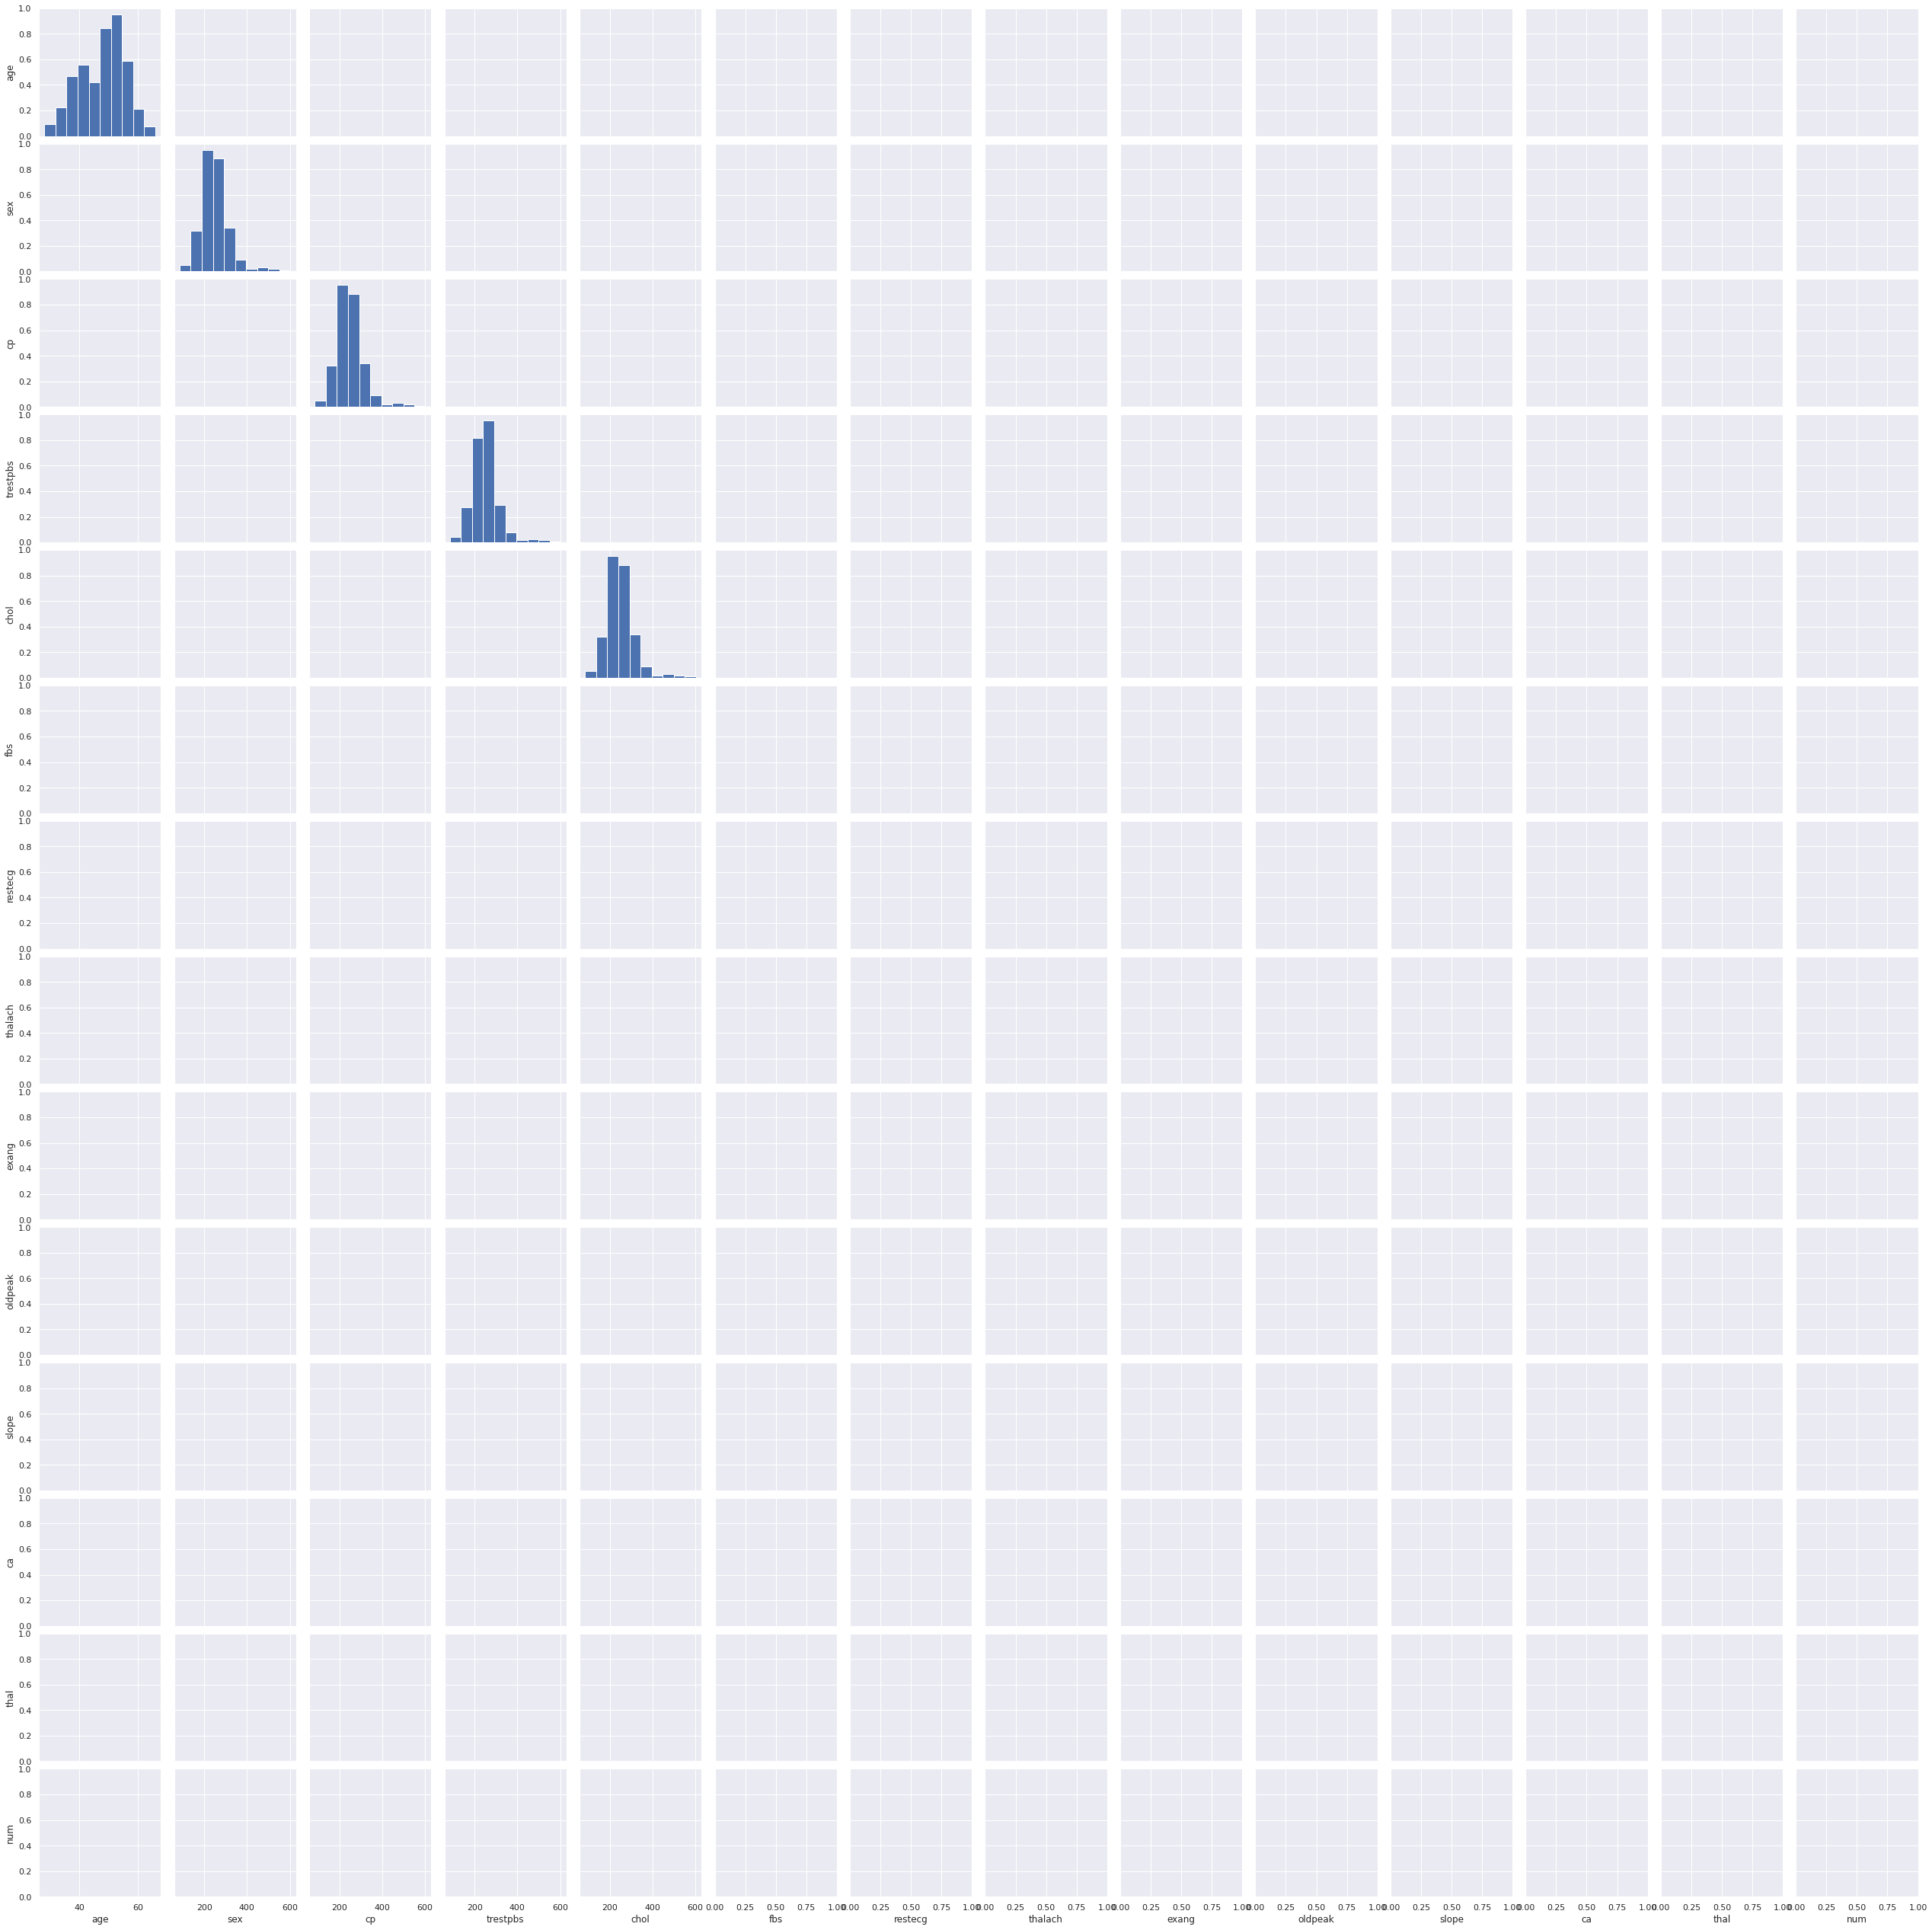

In [108]:
sns.pairplot(df)

In [135]:
df.head()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,132,132,132.0,132.0,0,2,185,0,0.0,2,0,7,0
1,29,243,243,243.0,243.0,0,0,160,0,0.0,2,0,7,0
2,29,230,230,230.0,230.0,0,0,170,0,0.0,2,0,7,0
3,30,237,237,237.0,237.0,0,1,170,0,0.0,2,0,6,0
4,31,219,219,219.0,219.0,0,1,150,0,0.0,2,0,7,0


In [136]:
df = df.dropna(inplace = True)

In [139]:
X = df.drop('num', axis = 1)
y = df[['num']]

AttributeError: 'NoneType' object has no attribute 'drop'

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [118]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(accuracy_score(y_test, y_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [140]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

In [ ]:
print("5-fold cross validation")

labels = ["Logistic Regression", "Random Forest", "Navive Bayes", "Bagging"]

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f(+/-%0.2f) [%s]" % (scores.mean(), scores.std(), label))